In [36]:
import pandas as pd
import numpy as np
import SRW_v044 as SRW
import pickle
import os
from google.colab import drive

In [47]:
# Base directory - modify these
BASE_DATA_DIR = "/content/drive/MyDrive/02712-final-project"
DATA_DIR = os.path.join(BASE_DATA_DIR, "coadread_processed")
OUTPUT_DIR = os.path.join(BASE_DATA_DIR, "coadread_results")

## Load COADREAD data

In [40]:
print("Loading COADREAD data...")

edges, features, node_names = SRW.load_network(os.path.join(DATA_DIR, 'COADREAD_edge2features.txt'))

Loading COADREAD data...
* Loading network...


/content/drive/MyDrive/02712-final-project-main/NBSS-code/SRW_v044.py:90: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  edges = df.iloc[:,:2].applymap(lambda x: node2index[x]).values


In [41]:
P_init_train, sample_names_train = SRW.load_samples(
    os.path.join(DATA_DIR, 'COADREAD_training_data.txt'),
    node_names
)

P_init_val, sample_names_val = SRW.load_samples(
    os.path.join(DATA_DIR, 'COADREAD_validation_data.txt'),
    node_names
)

	- Nodes in adjacency matrix: 511


/content/drive/MyDrive/02712-final-project-main/NBSS-code/SRW_v044.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  P_init = csr_matrix(P_init.fillna(0).values)


	- Nodes in adjacency matrix: 511


/content/drive/MyDrive/02712-final-project-main/NBSS-code/SRW_v044.py:117: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  P_init = csr_matrix(P_init.fillna(0).values)


In [42]:
# Load labels as simple list (one per line)
def load_labels_simple(filename):
    labels = []
    with open(filename) as f:
        for line in f.read().rstrip().splitlines():
            labels.append(line)
    return labels

group_labels_train = load_labels_simple(os.path.join(DATA_DIR, 'COADREAD_training_labels.txt'))
group_labels_val = load_labels_simple(os.path.join(DATA_DIR, 'COADREAD_validation_labels.txt'))

Remove patients with 0 mutations

In [43]:
# Filter training set
train_mut_counts = np.array(P_init_train.sum(axis=1)).flatten()
train_keep = train_mut_counts > 0

P_init_train_filtered = P_init_train[train_keep, :]
group_labels_train_filtered = [group_labels_train[i] for i in range(len(group_labels_train)) if train_keep[i]]

print(f"Training set: {P_init_train.shape[0]} → {P_init_train_filtered.shape[0]} patients")
print(f"Removed {(~train_keep).sum()} patients with 0 mutations")

# Filter validation set
val_mut_counts = np.array(P_init_val.sum(axis=1)).flatten()
val_keep = val_mut_counts > 0

P_init_val_filtered = P_init_val[val_keep, :]
group_labels_val_filtered = [group_labels_val[i] for i in range(len(group_labels_val)) if val_keep[i]]

print(f"Validation set: {P_init_val.shape[0]} → {P_init_val_filtered.shape[0]} patients")
print(f"Removed {(~val_keep).sum()} patients with 0 mutations")

# Check new label distribution
print("\nNew training label distribution:")
print(pd.Series(group_labels_train_filtered).value_counts())

print("\nNew validation label distribution:")
print(pd.Series(group_labels_val_filtered).value_counts())

Training set: 405 → 332 patients
Removed 73 patients with 0 mutations
Validation set: 200 → 154 patients
Removed 46 patients with 0 mutations

New training label distribution:
Colon       214
Rectal       76
Mucinous     42
Name: count, dtype: int64

New validation label distribution:
Colon       102
Rectal       35
Mucinous     17
Name: count, dtype: int64


In [46]:
# Load feature names
feature_names = []
with open(os.path.join(DATA_DIR, 'COADREAD_feature_names.txt')) as f:
    for line in f.read().rstrip().splitlines():
        feature_names.append(line)
feature_names.append('selfloop')
feature_names.append('intercept')

nnodes = len(node_names)

print(f"✓ Loaded {len(sample_names_train)} training samples")
print(f"✓ Loaded {len(sample_names_val)} validation samples")
print(f"✓ Network has {nnodes} nodes")

✓ Loaded 405 training samples
✓ Loaded 200 validation samples
✓ Network has 557 nodes


Run Logistic Regression as a baseline

In [44]:
# Logistic regression baseline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

print("\n" + "="*60)
print("LOGISTIC REGRESSION BASELINE TEST")
print("="*60)

X_train = P_init_train_filtered.toarray()
y_train = group_labels_train_filtered

X_val = P_init_val_filtered.toarray()
y_val = group_labels_val_filtered

# Train simple logistic regression
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

train_acc = lr.score(X_train, y_train)
val_acc = lr.score(X_val, y_val)

print(f"\nLogistic Regression (no network):")
print(f"  Training accuracy: {train_acc:.3f}")
print(f"  Validation accuracy: {val_acc:.3f}")


LOGISTIC REGRESSION BASELINE TEST

Logistic Regression (no network):
  Training accuracy: 0.898
  Validation accuracy: 0.617


Optimize over a grid of hyperparameters for beta, alpha, and lambda

In [45]:
# ==================================================
# SET HYPERPARAMETERS
# ==================================================
betas = [500, 1000, 2000]
alphas = [0.2, 0.3, 0.4, 0.5]
lambdas = [0.1]

results = []

In [ ]:
# ============================================
# GRID SEARCH
# ============================================
total = len(betas) * len(alphas) * len(lambdas)
counter = 0

for beta in betas:
    for alpha in alphas:
        for lam in lambdas:
            counter += 1
            print(f"\n[{counter}/{total}] Testing: β={beta}, α={alpha}, λ={lam}")

            try:
                SRW_obj = SRW.SRW_solver(
                    edges, features, nnodes,
                    P_init_train_filtered,
                    alpha,
                    group_labels_train_filtered,
                    lam=lam,
                    w_init_sd=0.01,
                    w=None,
                    feature_names=feature_names,
                    sample_names=sample_names_train,
                    node_names=node_names,
                    loss='WMW',
                    norm_type='L1',
                    learning_rate=0.2,
                    update_w_func='Adam',
                    P_init_val=P_init_val_filtered,
                    group_labels_val=group_labels_val_filtered,
                    ncpus=-1,
                    maxit=100,
                    early_stop=30,
                    WMW_b=beta
                )

                SRW_obj.train_SRW_GD()

                train_acc = SRW_obj.accuracy
                val_acc = SRW_obj.accuracy_val

                results.append({
                    'beta': beta,
                    'alpha': alpha,
                    'lambda': lam,
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                    'gap': train_acc - val_acc
                })

                print(f"  → Train: {train_acc:.3f}, Val: {val_acc:.3f}")

            except Exception as e:
                print(f"  → Failed: {e}")
                results.append({
                    'beta': beta,
                    'alpha': alpha,
                    'lambda': lam,
                    'train_acc': np.nan,
                    'val_acc': np.nan,
                    'gap': np.nan
                })
                continue

In [48]:
# Save results
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_DIR, 'hyperparam_sweep_main.txt'), index=False)

print(f"✓ Saved {len(results)} results so far")
print(f"Last tested: β={results[-1]['beta']}, α={results[-1]['alpha']}, λ={results[-1]['lambda']}")

✓ Saved 0 results so far


IndexError: list index out of range

Test extreme values for beta and lambda

In [49]:
# ==================================================
# TEST EXTREME HYPERPARAMETERS
# ==================================================
betas = [100, 5000]
alphas = [0.3, 0.4]
lambdas = [0.01, 0.5]

results = []

In [ ]:
# ============================================
# GRID SEARCH
# ============================================
total = len(betas) * len(alphas) * len(lambdas)
counter = 0

for beta in betas:
    for alpha in alphas:
        for lam in lambdas:
            counter += 1
            print(f"\n[{counter}/{total}] Testing: β={beta}, α={alpha}, λ={lam}")

            try:
                SRW_obj = SRW.SRW_solver(
                    edges, features, nnodes,
                    P_init_train_filtered,
                    alpha,
                    group_labels_train_filtered,
                    lam=lam,
                    w_init_sd=0.01,
                    w=None,
                    feature_names=feature_names,
                    sample_names=sample_names_train,
                    node_names=node_names,
                    loss='WMW',
                    norm_type='L1',
                    learning_rate=0.2,
                    update_w_func='Adam',
                    P_init_val=P_init_val_filtered,
                    group_labels_val=group_labels_val_filtered,
                    ncpus=-1,
                    maxit=100,
                    early_stop=30,
                    WMW_b=beta
                )

                SRW_obj.train_SRW_GD()

                train_acc = SRW_obj.accuracy
                val_acc = SRW_obj.accuracy_val

                results.append({
                    'beta': beta,
                    'alpha': alpha,
                    'lambda': lam,
                    'train_acc': train_acc,
                    'val_acc': val_acc,
                    'gap': train_acc - val_acc
                })

                print(f"  → Train: {train_acc:.3f}, Val: {val_acc:.3f}")

            except Exception as e:
                print(f"  → Failed: {e}")
                results.append({
                    'beta': beta,
                    'alpha': alpha,
                    'lambda': lam,
                    'train_acc': np.nan,
                    'val_acc': np.nan,
                    'gap': np.nan
                })
                continue

In [ ]:
# Save results
df_results = pd.DataFrame(results)
df_results.to_csv(os.path.join(OUTPUT_DIR, 'hyperparam_sweep_extreme.txt'), index=False)

print(f"✓ Saved {len(results)} results so far")
print(f"Last tested: β={results[-1]['beta']}, α={results[-1]['alpha']}, λ={results[-1]['lambda']}")

Combine and visualize results from hyperparameter sweeps

COMBINING RESULTS FROM ALL NOTEBOOKS
✓ Loaded notebook 1: 6 results
✓ Loaded notebook 2: 6 results
✓ Loaded notebook 3: 8 results

✓ Combined: 20 total results

BEST HYPERPARAMETERS
  β (WMW_b): 500.0
  α (restart prob): 0.3
  λ (regularization): 0.1

Performance:
  Training accuracy: 0.461
  Validation accuracy: 0.481
  Train/Val gap: -0.020

TOP 10 PARAMETER COMBINATIONS
 beta  alpha  lambda  train_acc  val_acc       gap
  500    0.3    0.10   0.460843 0.480519 -0.019676
 1000    0.3    0.10   0.457831 0.480519 -0.022688
 2000    0.3    0.10   0.460843 0.480519 -0.019676
  500    0.2    0.10   0.460843 0.480519 -0.019676
 1000    0.2    0.10   0.460843 0.480519 -0.019676
 2000    0.2    0.10   0.457831 0.480519 -0.022688
  100    0.3    0.01   0.460843 0.480519 -0.019676
  100    0.3    0.50   0.460843 0.480519 -0.019676
 5000    0.3    0.50   0.463855 0.480519 -0.016664
  500    0.4    0.10   0.460843 0.474026 -0.013183


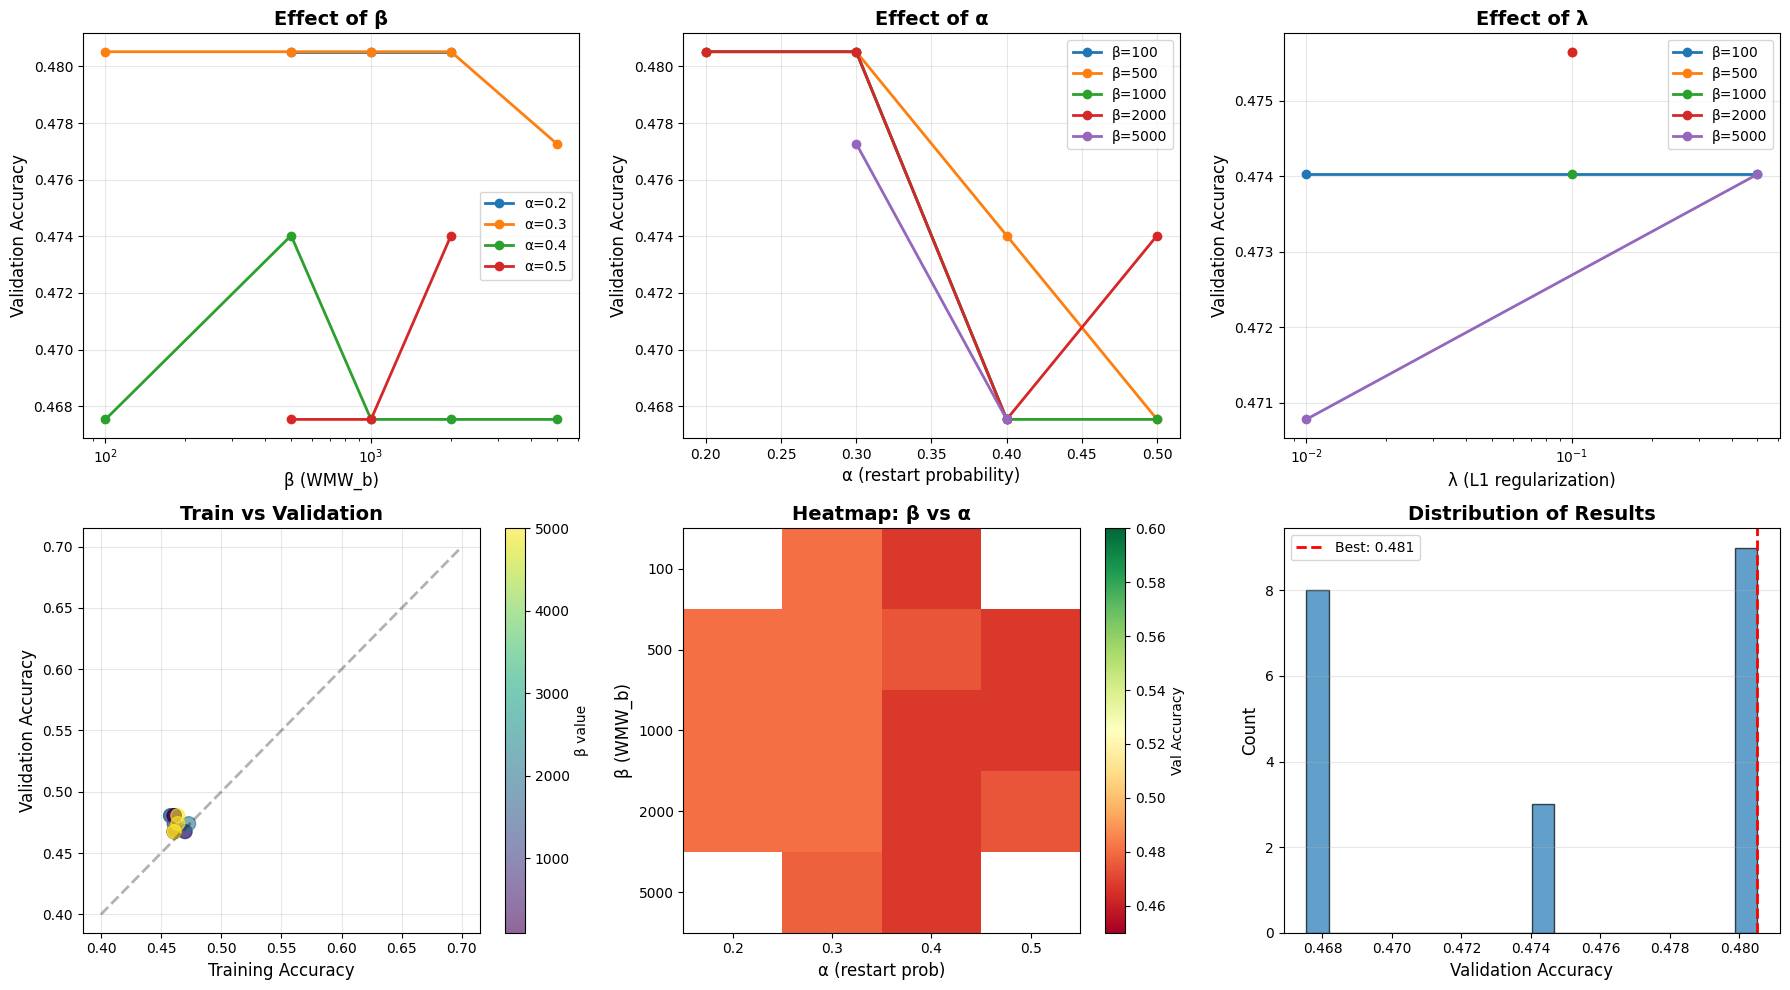


✓ Plots saved to: hyperparameter_optimization.png
✓ Combined results saved to: hyperparam_sweep_ALL.csv

COMPARISON TO PAPER
  BRCA (paper): ~0.68 validation accuracy (4 subtypes, max corr 0.76)
  GBM (paper): ~0.64 validation accuracy (5 subtypes)
  COADREAD (yours): 0.481 validation accuracy (3 subtypes, max corr 0.85)

  Correlation explains the gap:
    BRCA max correlation: 0.76
    Your max correlation: 0.85 (Colon vs Rectal)
    Higher correlation → harder to separate → lower accuracy


In [ ]:
# ============================================
# COMBINE RESULTS & ANALYSIS
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("="*60)
print("COMBINING RESULTS")
print("="*60)

# Load all results
dfs = []
df_main = pd.read_csv(os.path.join(OUTPUT_DIR, 'hyperparam_sweep_main.txt'))
dfs.append(df_main)
df_extreme = pd.read_csv(os.path.join(OUTPUT_DIR, 'hyperparam_sweep_extreme.txt'))
dfs.append(df_extreme)
df_all = pd.concat(dfs, ignore_index=True)

print(f"\n✓ Combined: {len(df_all)} total results")

# Remove failed runs
df_all = df_all.dropna()

# Find best overall
best_idx = df_all['val_acc'].idxmax()
best = df_all.loc[best_idx]

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
print(f"  β (WMW_b): {best['beta']}")
print(f"  α (restart prob): {best['alpha']}")
print(f"  λ (regularization): {best['lambda']}")
print(f"\nPerformance:")
print(f"  Training accuracy: {best['train_acc']:.3f}")
print(f"  Validation accuracy: {best['val_acc']:.3f}")
print(f"  Train/Val gap: {best['gap']:.3f}")

# Top 10
print(f"\n{'='*60}")
print("TOP 10 PARAMETER COMBINATIONS")
print("="*60)
top10 = df_all.nlargest(10, 'val_acc')[['beta', 'alpha', 'lambda', 'train_acc', 'val_acc', 'gap']]
print(top10.to_string(index=False))

# ============================================
# VISUALIZATIONS
# ============================================

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot 1: β vs accuracy
for alpha_val in sorted(df_all['alpha'].unique()):
    subset = df_all[df_all['alpha'] == alpha_val].groupby('beta')['val_acc'].mean()
    axes[0,0].plot(subset.index, subset.values, 'o-', label=f'α={alpha_val}', linewidth=2)
axes[0,0].set_xlabel('β (WMW_b)', fontsize=12)
axes[0,0].set_ylabel('Validation Accuracy', fontsize=12)
axes[0,0].set_title('Effect of β', fontsize=14, fontweight='bold')
axes[0,0].set_xscale('log')
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

# Plot 2: α vs accuracy
for beta_val in sorted(df_all['beta'].unique()):
    subset = df_all[df_all['beta'] == beta_val].groupby('alpha')['val_acc'].mean()
    axes[0,1].plot(subset.index, subset.values, 'o-', label=f'β={beta_val}', linewidth=2)
axes[0,1].set_xlabel('α (restart probability)', fontsize=12)
axes[0,1].set_ylabel('Validation Accuracy', fontsize=12)
axes[0,1].set_title('Effect of α', fontsize=14, fontweight='bold')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3: λ vs accuracy
for beta_val in sorted(df_all['beta'].unique()):
    subset = df_all[df_all['beta'] == beta_val].groupby('lambda')['val_acc'].mean()
    axes[0,2].plot(subset.index, subset.values, 'o-', label=f'β={beta_val}', linewidth=2)
axes[0,2].set_xlabel('λ (L1 regularization)', fontsize=12)
axes[0,2].set_ylabel('Validation Accuracy', fontsize=12)
axes[0,2].set_title('Effect of λ', fontsize=14, fontweight='bold')
axes[0,2].set_xscale('log')
axes[0,2].legend()
axes[0,2].grid(True, alpha=0.3)

# Plot 4: Train vs Val accuracy
scatter = axes[1,0].scatter(df_all['train_acc'], df_all['val_acc'],
                            c=df_all['beta'], cmap='viridis', s=100, alpha=0.6)
axes[1,0].plot([0.4, 0.7], [0.4, 0.7], 'k--', alpha=0.3, linewidth=2)
axes[1,0].set_xlabel('Training Accuracy', fontsize=12)
axes[1,0].set_ylabel('Validation Accuracy', fontsize=12)
axes[1,0].set_title('Train vs Validation', fontsize=14, fontweight='bold')
axes[1,0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1,0], label='β value')

# Plot 5: Heatmap (β vs α)
pivot = df_all.groupby(['beta', 'alpha'])['val_acc'].mean().unstack()
im = axes[1,1].imshow(pivot.values, cmap='RdYlGn', aspect='auto', vmin=0.45, vmax=0.6)
axes[1,1].set_xticks(range(len(pivot.columns)))
axes[1,1].set_xticklabels([f'{x:.1f}' for x in pivot.columns])
axes[1,1].set_yticks(range(len(pivot.index)))
axes[1,1].set_yticklabels(pivot.index)
axes[1,1].set_xlabel('α (restart prob)', fontsize=12)
axes[1,1].set_ylabel('β (WMW_b)', fontsize=12)
axes[1,1].set_title('Heatmap: β vs α', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=axes[1,1], label='Val Accuracy')

# Plot 6: Distribution of results
axes[1,2].hist(df_all['val_acc'], bins=20, edgecolor='black', alpha=0.7)
axes[1,2].axvline(best['val_acc'], color='red', linestyle='--', linewidth=2, label=f'Best: {best["val_acc"]:.3f}')
axes[1,2].set_xlabel('Validation Accuracy', fontsize=12)
axes[1,2].set_ylabel('Count', fontsize=12)
axes[1,2].set_title('Distribution of Results', fontsize=14, fontweight='bold')
axes[1,2].legend()
axes[1,2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'hyperparameter_optimization.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Plots saved to: hyperparameter_optimization.png")

# Save combined results
df_all.to_csv(os.path.join(OUTPUT_DIR, 'hyperparam_sweep_ALL.txt'), index=False)
print(f"✓ Combined results saved to: hyperparam_sweep_ALL.csv")

# ============================================
# COMPARISON TO PAPER
# ============================================
print(f"\n{'='*60}")
print("COMPARISON TO PAPER")
print("="*60)
print(f"  BRCA (paper): ~0.68 validation accuracy (4 subtypes, max corr 0.76)")
print(f"  GBM (paper): ~0.64 validation accuracy (5 subtypes)")
print(f"  COADREAD (yours): {best['val_acc']:.3f} validation accuracy (3 subtypes, max corr 0.85)")
print(f"\n  Correlation explains the gap:")
print(f"    BRCA max correlation: 0.76")
print(f"    Your max correlation: 0.85 (Colon vs Rectal)")
print(f"    Higher correlation → harder to separate → lower accuracy")
print("="*60)